In [1]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from torch.utils.data import DataLoader
from sklearn import preprocessing
import fasttext as ft
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import copy

### Глобальные переменные

In [2]:
DATA_DIR  = 'ner_dataset.csv'

NUM_EPOCHS = 10
BATCH_SIZE = 128
START_LR = 1e-3
EMBED_DIM = 300
MAX_LEN = 128
MODEL_PATH = "./state_dict.pt"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Загрузка датасета

In [3]:
df = pd.read_csv('ner_dataset.csv', encoding='unicode_escape')
df['Tag'].unique()

array(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim',
       'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve',
       'I-eve', 'I-nat'], dtype=object)

In [4]:
def process_data(data_path):
    df = pd.read_csv(data_path, encoding='unicode_escape')
    
    enc_tag = preprocessing.LabelEncoder()

    df.loc[:, "Sentence #"] = df["Sentence #"].fillna(method="ffill")
    df.loc[:, "Tag"] = enc_tag.fit_transform(df["Tag"])

    sentences = df.groupby("Sentence #")["Word"].apply(list).values
    tag = df.groupby("Sentence #")["Tag"].apply(list).values
    return sentences, tag, enc_tag

In [5]:
sentences, tag, enc_tag = process_data(DATA_DIR)

C:\Users\Sanya\AppData\Local\Temp\ipykernel_15088\1310700271.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.loc[:, "Sentence #"] = df["Sentence #"].fillna(method="ffill")


In [6]:
print(sentences[0])
print(tag[0])

['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.']
[16, 16, 16, 16, 16, 16, 2, 16, 16, 16, 16, 16, 2, 16, 16, 16, 16, 16, 3, 16, 16, 16, 16, 16]


### Загружаем fasttext для предобработки текста

In [7]:
fasttext_model = ft.load_model("cc.en.300.bin")

### Работа с датасетом

In [8]:
t = [1, 2, 3 , 4]
np.pad(t, (0,2) , 'constant', constant_values=0)

array([1, 2, 3, 4, 0, 0])

In [9]:
class EntityDataset:
    def __init__(self, texts, tags):
        """
        Сразу предобрабатываем данные для более ускоренного вычисления
        """
        self.texts = np.array([[fasttext_model.get_word_vector(w) for w in np.pad(text, (0, MAX_LEN - len(text)), 'constant', constant_values = '')] for text in texts])
        self.tags = np.array([np.pad(tag, (0,MAX_LEN - len(tag)), 'constant', constant_values=0) for tag in tags])
        self.masks = [np.concatenate([np.ones(len(tag)), np.zeros(MAX_LEN - len(tag))]) for tag in tags]
        self.masks = np.array(self.masks)
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, item):       
        return (torch.tensor(self.texts[item], dtype=torch.float32),
                torch.tensor(self.tags[item], dtype=torch.long),
                torch.tensor(self.masks[item], dtype=torch.long))

In [10]:
""" 
Разделение датасета на тренировочную, валидационную и тестовую выборку
"""
X_train, X_valid, y_train, y_valid = train_test_split(sentences, tag, test_size=0.33, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split( X_valid, y_valid, test_size=0.5, random_state=42)

In [11]:
data = {
    'train':
        EntityDataset(texts=X_train, tags=y_train),
    'validation':
        EntityDataset(texts=X_valid, tags=y_valid),
    'test':
        EntityDataset(texts=X_valid, tags=y_valid),
}

""" 
Загрузка данных на устройство 
"""
loaders = {
    'train':
        DataLoader(data['train'], batch_size=BATCH_SIZE, shuffle=False, num_workers=0, drop_last=True),
    'validation':
        DataLoader(data['validation'], batch_size=BATCH_SIZE, shuffle=False, num_workers=0, drop_last=True),
    'test':
        DataLoader(data['test'], batch_size=BATCH_SIZE, shuffle=False, num_workers=0, drop_last=True),

}

### Создание модели

In [12]:
class EntityModel(nn.Module):
    def __init__(self, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5, bidirectional=False):
        super().__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True, bidirectional=bidirectional)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, embeds, hidden):

        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        dropout = self.dropout(lstm_out)
        out = self.fc(dropout)

        return out, hidden
    
    def init_hidden(self, batch_size):

        num_directions = 2 if self.lstm.bidirectional else 1
        print("num_directions", num_directions)

        h_zeros = torch.zeros(self.n_layers * num_directions,
                              batch_size, self.hidden_dim,
                              dtype=torch.float32, device=DEVICE)
        
        c_zeros = torch.zeros(self.n_layers * num_directions,
                              batch_size, self.hidden_dim,
                              dtype=torch.float32, device=DEVICE)

        return (h_zeros, c_zeros)

In [13]:
def loss_fn(output, target, mask, num_labels):
    """ 
    Функция для вычисления потерь модели
    """
    lfn = nn.CrossEntropyLoss()
    active_loss = mask.view(-1) == 1
    active_logits = output.view(-1, num_labels)
    active_labels = torch.where(
        active_loss,
        target.view(-1),
        torch.tensor(lfn.ignore_index).type_as(target)
    )
    loss = lfn(active_logits, active_labels)
    return loss

In [14]:
def acc_stat(pred, target, mask):
    """
    Функция оценки точности модели 
    """
    mask = mask.bool()
    pred = torch.masked_select(pred, mask)
    target = torch.masked_select(target, mask)
    correct = torch.sum(target == pred)
    total = len(target)
    return correct, total

In [15]:
hidden_dim = 512
n_layers = 2
num_tag = len(list(enc_tag.classes_))

model = EntityModel(num_tag, EMBED_DIM, hidden_dim, n_layers, drop_prob=0.5, bidirectional=False)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=START_LR)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=5e-5)

c:\Users\Sanya\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Обучение модели

In [16]:
train_losses = []
valid_losses = []

train_acc = []
valid_acc = []

def train_model(model, optimizer, num_epochs=NUM_EPOCHS):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
    
        h = model.init_hidden(BATCH_SIZE)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            correct_sum, total_sum = 0, 0
            running_loss = 0

            for inputs, labels, masks in loaders[phase]:
                h = tuple([each.data for each in h])

                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)
                masks = masks.to(DEVICE)

                model.zero_grad()
                outputs, h = model(inputs, h)
                loss = loss_fn(outputs, labels.flatten(), masks, num_tag)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                corrects, total =  acc_stat(torch.argmax(outputs, dim=-1).flatten(), labels.flatten(), masks.flatten())
                correct_sum += corrects
                total_sum += total 
                
            epoch_loss = running_loss / total_sum
            epoch_acc = correct_sum.double() / total_sum
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_acc.append(epoch_acc.cpu())
            else:
                valid_losses.append(epoch_loss)
                valid_acc.append(epoch_acc.cpu())

                if best_acc < epoch_acc: 
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        100*epoch_acc))
    return model.load_state_dict(best_model_wts)

train_model(model, optimizer)

Epoch 1/10
----------
num_directions 1
train loss: 0.0260, acc: 86.8333
validation loss: 0.0119, acc: 91.7955
Epoch 2/10
----------
num_directions 1
train loss: 0.0098, acc: 93.7332
validation loss: 0.0076, acc: 95.2711
Epoch 3/10
----------
num_directions 1
train loss: 0.0077, acc: 95.2043
validation loss: 0.0067, acc: 95.6736
Epoch 4/10
----------
num_directions 1
train loss: 0.0070, acc: 95.5078
validation loss: 0.0063, acc: 95.8440
Epoch 5/10
----------
num_directions 1
train loss: 0.0066, acc: 95.7151
validation loss: 0.0061, acc: 95.9392
Epoch 6/10
----------
num_directions 1
train loss: 0.0063, acc: 95.8316
validation loss: 0.0060, acc: 96.0326
Epoch 7/10
----------
num_directions 1
train loss: 0.0060, acc: 95.9775
validation loss: 0.0058, acc: 96.0726
Epoch 8/10
----------
num_directions 1
train loss: 0.0058, acc: 96.0688
validation loss: 0.0058, acc: 96.0949
Epoch 9/10
----------
num_directions 1
train loss: 0.0056, acc: 96.1516
validation loss: 0.0057, acc: 96.1354
Epoch 10/1

<All keys matched successfully>

### Графики обучения модели

Text(0, 0.5, 'Loss')

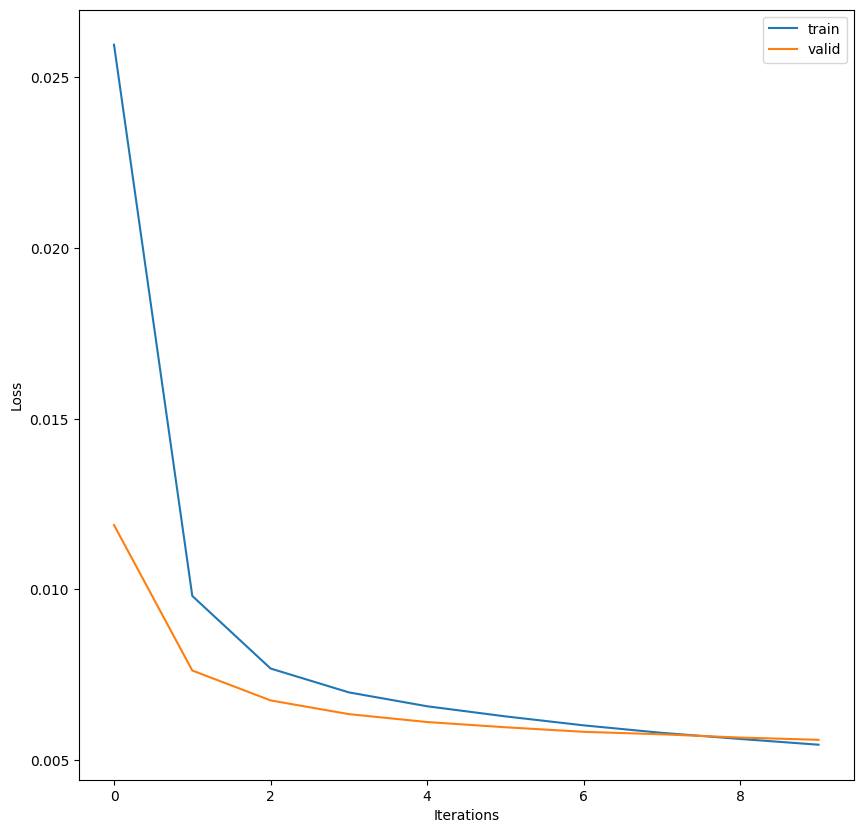

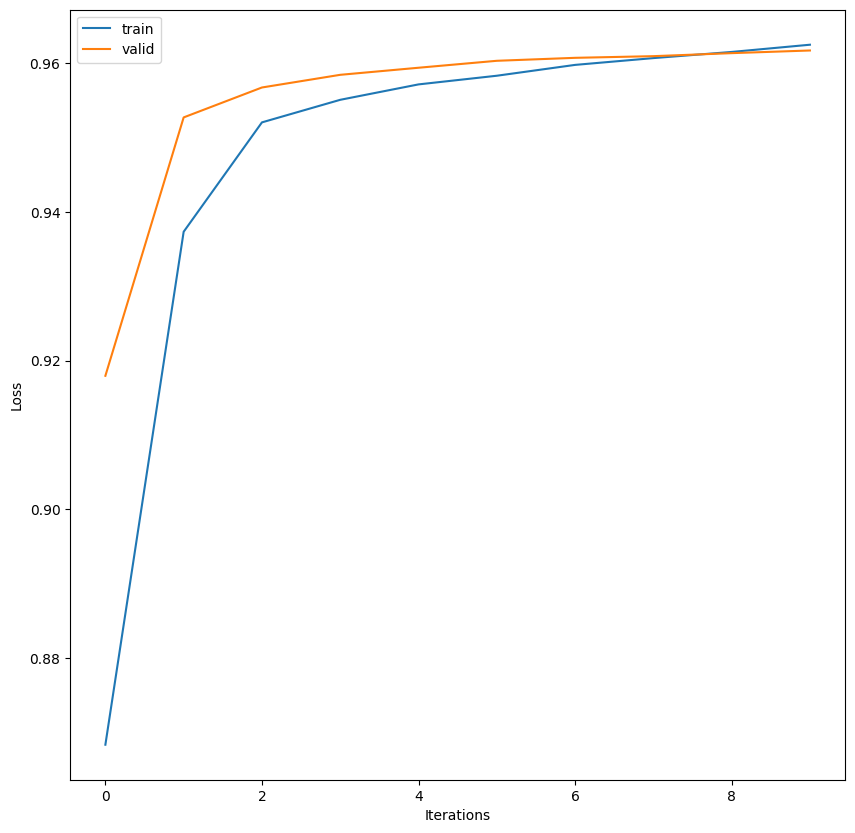

In [17]:
fig = plt.figure(figsize=(10, 10))

plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')

fig = plt.figure(figsize=(10, 10))

plt.plot(train_acc, label='train')
plt.plot(valid_acc, label='valid')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')

### Тестирование модели

In [18]:
h = model.init_hidden(BATCH_SIZE)    
correct_sum, total_sum = 0, 0
with torch.no_grad():
    for inputs, labels, masks in loaders['test']:
        h = tuple([each.data for each in h])
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        masks = masks.to(DEVICE)
        
        model.zero_grad()
        output, h = model(inputs, h)
            
        correct, total = acc_stat(torch.argmax(output, dim=-1).flatten(), labels.flatten(), masks.flatten())
        correct_sum += correct
        total_sum += total
print('Test acc: {:.4f}'.format( 100*correct_sum/total_sum))

num_directions 1
Test acc: 96.1724


### Тестируем модель на собственном предложении

In [19]:
text = """
Sonya Volodina was born in Barnaul
"""
with torch.no_grad():
    inputs = torch.tensor([fasttext_model.get_word_vector(s) for s in word_tokenize(text)], dtype=torch.float32)
    inputs = inputs.unsqueeze(0).to(DEVICE)
    h = model.init_hidden(1)
    tag, h = model(inputs, h)

    print(
        enc_tag.inverse_transform(
            tag.argmax(-1).cpu().numpy().reshape(-1)
        )
    )

num_directions 1
['B-per' 'I-per' 'O' 'O' 'O' 'B-geo']


C:\Users\Sanya\AppData\Local\Temp\ipykernel_15088\2656275636.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:264.)
  inputs = torch.tensor([fasttext_model.get_word_vector(s) for s in word_tokenize(text)], dtype=torch.float32)
